This notebook reads a Topas CSV and Acuros xml files. Then, it can plot the dose deposition curves for a given energy.

In [ ]:
#Import ET to read XML files
import xml.etree.ElementTree as ET

#Import interpolation to get MU to proton number curve
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

import pandas as pd

In [ ]:
def xml_curve(path,idx):

  #Read the xml file
  tree = ET.parse(path)
  root = tree.getroot()

  #Initiate lists for x any y axes values
  position = []
  values = []

  #Obtain curve data points from xml file. Break single string into a list
  data = root[0][idx].text.split(';')
  #Remove last blank value in list
  data.pop()

  #Iterate over every data point and add values to respective list
  for item in data:
    case = item.split(',')
    position.append(float(case[0]))
    values.append(float(case[1]))

  #Use scipy interpolation function to create a curve
  curve = interp1d(position,values,kind='linear',fill_value="extrapolate")

  return curve


In [ ]:
def Topas_parameters(energy):
  '''
  Takes a given energy and resturns the mean energy and standard deviation that
  would be obtained for a ProBeam machine
  '''
  #Read xml conversion curves
  real_meanE = xml_curve('/content/drive/MyDrive/004_option01_energyspectrummean.xml',0)
  energy_sigma = xml_curve('/content/drive/MyDrive/004_option01_energyspectrumsigma.xml',0)

  #Determine the mean energy
  eng = real_meanE(energy)
  #Determine the percentage energy spread
  spread = 100 * energy_sigma(energy)/real_meanE(energy)

  return eng, spread

In [ ]:
Topas_parameters(180)

(array(180.075), 0.703784534221852)

In [ ]:
def compare_curves(csv, energy, xmax):
  '''
  Plots the depth deposition curves of proton beams with a given energy in MeV, up 
  to a given depth xmax.
  Topas data obtained through csv file. Acuros data from xml file
  '''

  #Read the Topas CSV file
  df = pd.read_csv(csv, error_bad_lines=False)
  #Obtain Topas percentage depth doses
  topas = df["Dose"]/max(df["Dose"])
  #Establish the depths of each dose measurement
  zval = 400 - 0.1*df["z"]

  #Read the measured data curves
  xml1 = '/content/004_option01_measureddepthdose.xml'
  index = int((energy-70)/5)
  acuros1 = xml_curve(xml1,index)

  #Read the calculated data curves
  xml2 = '/content/004_option01_calculateddepthdose.xml'
  acuros2 = xml_curve(xml2,index)

  #Create the plot
  plt.plot(zval,topas,label = "Topas")
  plt.plot(zval,acuros1(zval)/max(acuros1(zval)),label = "Measured Acuros")
  plt.plot(zval,acuros2(zval)/max(acuros2(zval)),label = "Calculated Acuros")
  plt.xlim(left=200,right= xmax)
  plt.title("Comparison between Topas and Acuros for " + str(energy) +"MeV Protons")
  plt.xlabel("Depth (mm)")
  plt.ylabel("Percentage Depth Dose")
  plt.legend()


  return topas

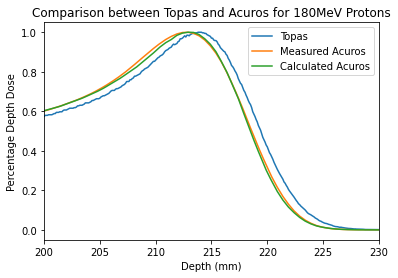

In [ ]:
array = compare_curves("/content/drive/MyDrive/TestEnergies/E180MeV.csv",180,230)
